<a href="https://colab.research.google.com/github/arinaruck/RL2021/blob/main/deep_crossentropy_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://tip.duke.edu/independent_learning/greek/lesson/digging_deeper_final.jpg)



In [ ]:
import sys, os
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


state vector dim = 4
n_actions = 2


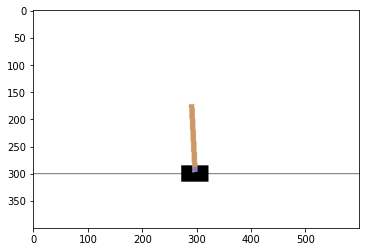

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [ ]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
print(np.array([env.reset()] * n_actions).shape)

(2, 4)


In [ ]:
def generate_session_with_agent(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(np.array(s).reshape(1, -1)).reshape(-1)

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [ ]:
dummy_states, dummy_actions, dummy_reward = generate_session_with_agent(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.04575489 -0.01327543 -0.0235162   0.04651106]
 [-0.0460204  -0.20805241 -0.02258598  0.33168263]
 [-0.05018145 -0.40284571 -0.01595233  0.61715834]
 [-0.05823836 -0.59774122 -0.00360916  0.90477463]
 [-0.07019318 -0.40257058  0.01448633  0.61095948]]
actions: [0, 0, 0, 1, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [ ]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    for reward, states, actions in zip(rewards_batch, states_batch, actions_batch):
        if reward > reward_threshold:
            elite_states.extend(states)
            elite_actions.extend(actions)
    
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [ ]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10], ax=None, title=None, size=None):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    mean_reward, threshold = log[-1][0], log[-1][1]

    if ax is not None:
        row, col = size
        plt.subplot(row, col, ax)
        plt.plot(list(zip(*log))[0], label=f'Mean rewards, final mean={mean_reward:.2f}')
        plt.plot(list(zip(*log))[1], label=f'Reward thresholds, final threshold={threshold:.2f}')
        plt.legend()
        plt.grid()
        plt.title(title)
    else:
        clear_output(True)
        print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(list(zip(*log))[0], label='Mean rewards')
        plt.plot(list(zip(*log))[1], label='Reward thresholds')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards_batch, range=reward_range)
        plt.vlines([np.percentile(rewards_batch, percentile)],
                  [0], [100], label="percentile", color='red')
        plt.legend()
        plt.grid()

        plt.show()

mean reward = 211.710, threshold=179.000


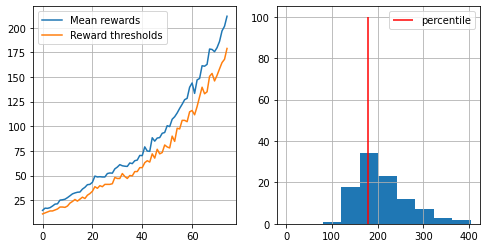




100%|██████████| 75/75 [02:36<00:00,  2.09s/it]

You Win! You may stop training now via KeyboardInterrupt.


In [ ]:
from tqdm import tqdm
n_sessions = 100
percentile = 35
log = []

env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))


for i in tqdm(range(75)):
    # generate new sessions
    sessions = [generate_session_with_agent(env, agent) for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [ ]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session_with_agent(env_monitor, agent) for _ in range(100)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [ ]:
env = gym.make("Taxi-v3")
s = env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        a = np.random.choice(n_actions, p=policy[s])

        new_s, r, done, info = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

In [ ]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for state, action in zip(elite_states, elite_actions):
        new_policy[state][action] += 1

    sums = np.sum(new_policy, axis=1)
    new_policy[sums == 0] = 1
    sums = np.sum(new_policy, axis=1, keepdims=True)
    new_policy /= sums

    return new_policy

In [ ]:
n_states = env.observation_space.n
n_actions = env.action_space.n


def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    return policy

def train(n_sessions=250, percentile=50, learning_rate=0.5, ax=None, title=None):
    log = []
    policy = initialize_policy(n_states, n_actions)
    for i in range(100):
        sessions = [generate_session(env, policy, t_max=10**4) for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        new_policy = get_new_policy(elite_states, elite_actions)

        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        mean_reward = np.mean(rewards_batch)
        threshold = np.percentile(rewards_batch, percentile)
        log.append([mean_reward, threshold])

    show_progress(rewards_batch, log, percentile, ax=ax, title=title, size=(5, 5))

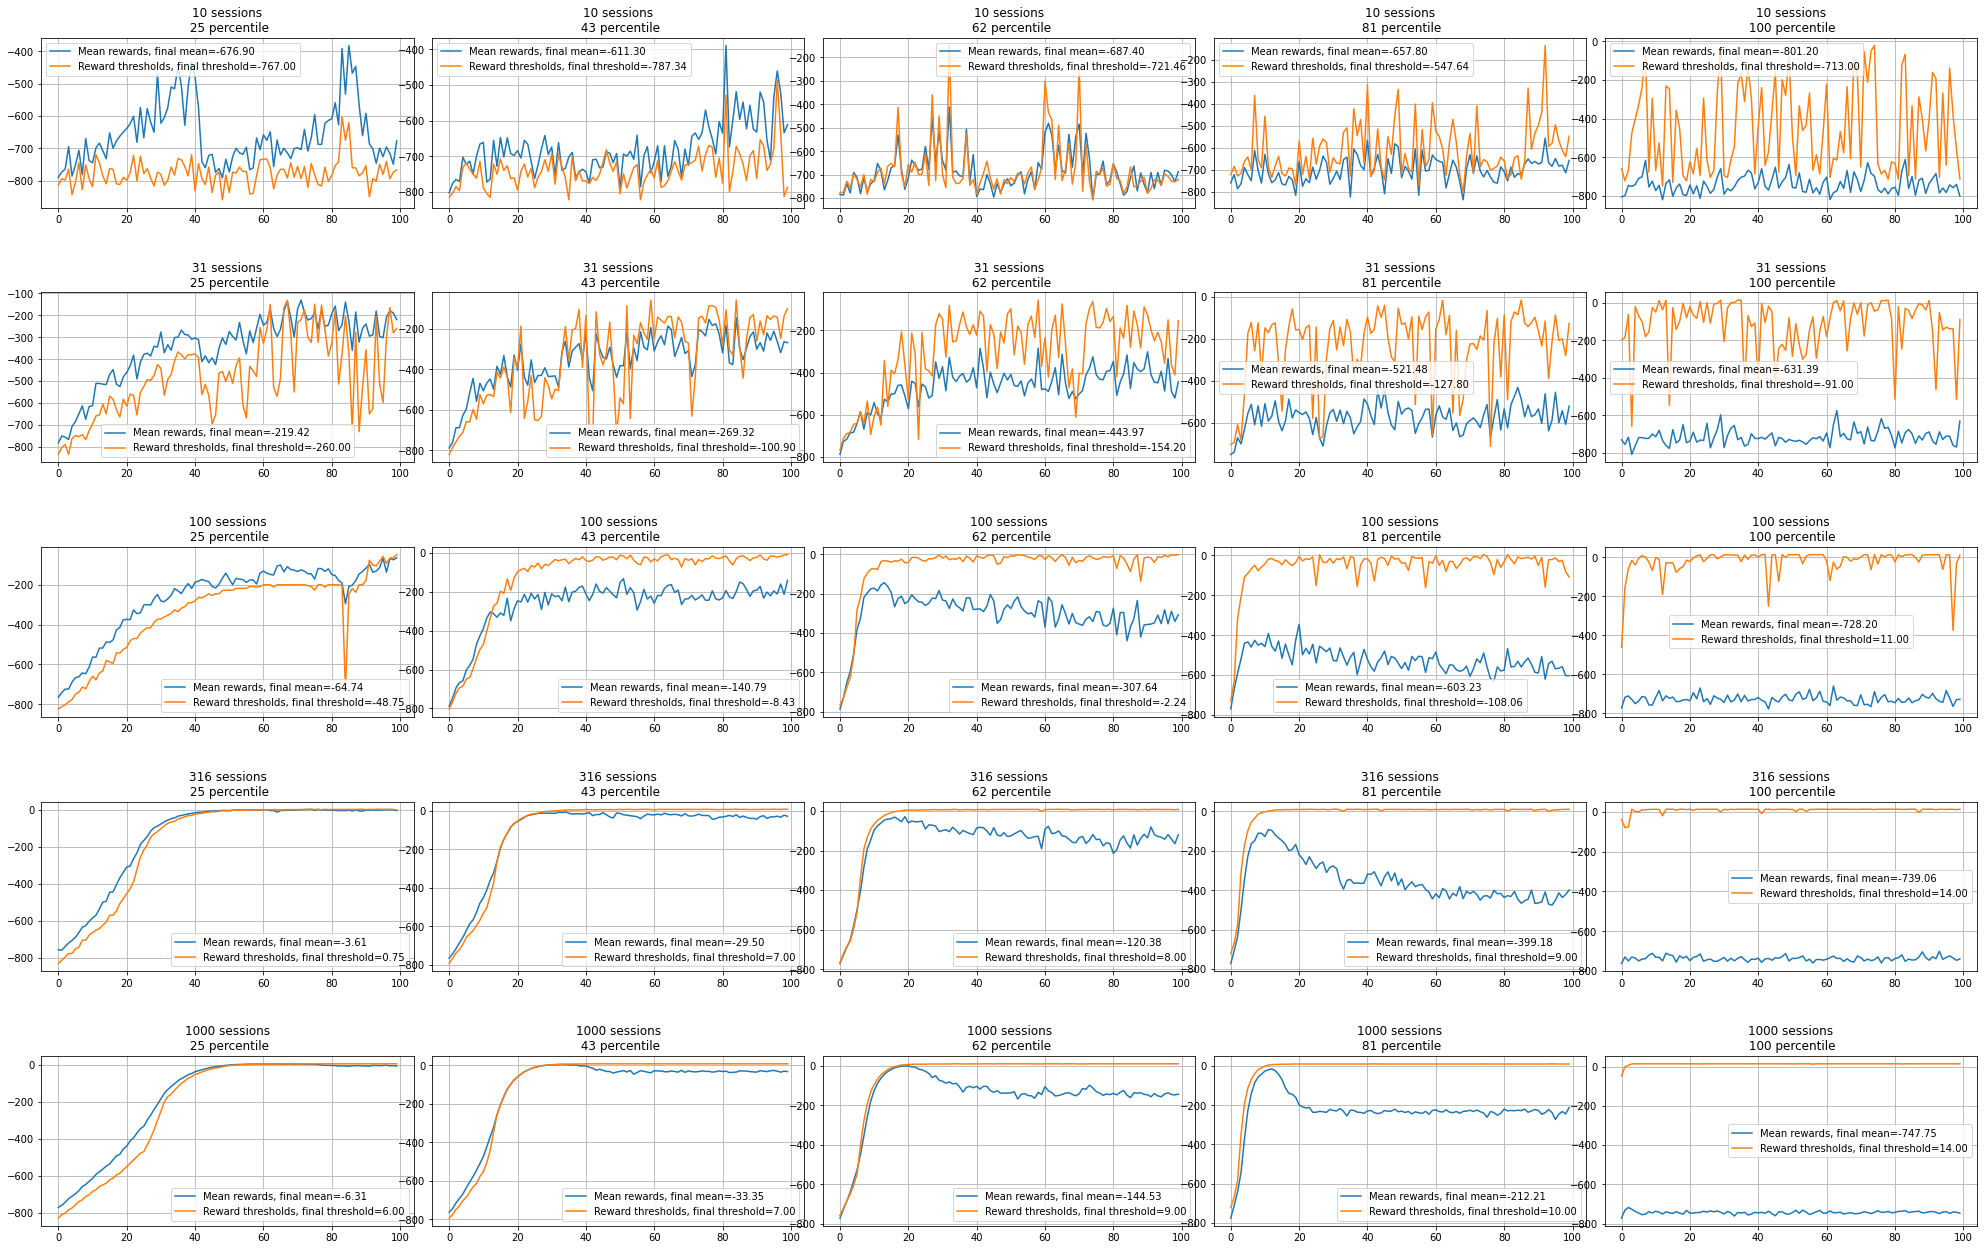

In [ ]:
plt.figure(figsize=(5 * 5 + 3, 5 * 4))
plt.subplots_adjust(left=.02, right=.98, bottom=.075, top=.9, wspace=.05,
                    hspace=.5)

for i, n_sessions in enumerate(np.logspace(1, 3, num=5, dtype=int)):
    for j, percentile in enumerate(np.linspace(25, 100, num=5, dtype=int)):
        train(n_sessions=n_sessions, percentile=percentile, ax=i * 5 + j + 1, title=f'{n_sessions} sessions\n {percentile} percentile')

From a reasonable amount of sessions 100+ the final threshold is around 0 ($\pm$ 10)


It can be seen that with the number of sessions, final mean reward increases. Therefore the more we train, the better the results. Possibly, the effect will saturate with even higher number of sessions, but it takes too long to plot even those results, so I'll experiment more with the next task and joblib. 

Another visible dependancy is that final mean reward is decreasing when percentile (so the elite reward threshold) is increasing. That can be explained since we are changing the balance between exploration and exploitation. (The higher the percentile, the less we explore). With a really high percentile, say, a corner case of 100 the outcome depends on the randomness a lot, since just only one (or a few similar in reward) action is selected as the true one. The descend from a near optimal score to a -100/-50 is also present only for the higher percentile values since the more we explore, the more ready we are for the innate randomness of the environment: changing starting and ending points.

Based on those results an even lower percentile and 100+ number of sessions should lead to a positive mean reward.

mean reward = 4.096, threshold=2.000


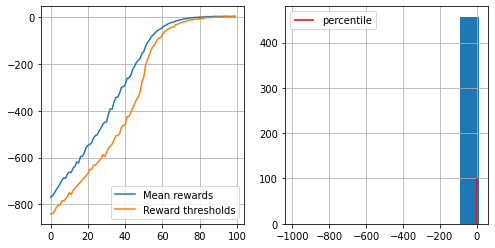

In [ ]:
best_percentile = 15
best_sessions = 500
train(n_sessions=best_sessions, percentile=best_percentile)

# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Experiment with the number of training iterations and learning rate of the neural network (see params). Provide some plots as in 1.1. (2 pts)
  
__Please list what you did in Anytask submission form__. 
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

state vector dim = 2
n_actions = 3


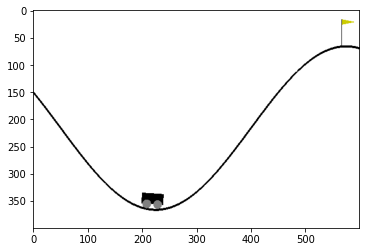

In [ ]:
env = gym.make("MountainCar-v0").env

np.random.seed(1992)
n_sessions = 500
percentile = 45 

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [ ]:
def init(env, lr=0.001, num_iters=200):
    env.reset()
    agent = MLPClassifier(
        hidden_layer_sizes=(20, 20),
        activation='tanh',
        learning_rate_init=lr,
        max_iter=num_iters
    )

    n_actions = env.action_space.n
    # initialize agent to the dimension of state space and number of actions
    agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions));
    return env, agent

mean reward = -126.500, threshold=-115.000


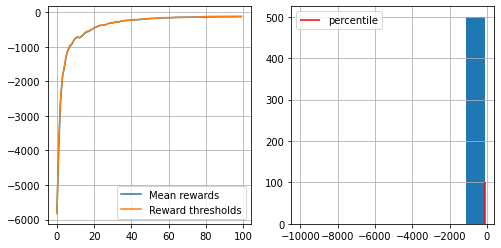

100%|██████████| 100/100 [1:26:41<00:00, 52.01s/it]

You Win! You may stop training now via KeyboardInterrupt.


In [ ]:
from tqdm import tqdm

np.random.seed(1992)
n_sessions = 500
percentile = 45
min_reward = -150
log = []
env, agent_mountain_car = init(env)

for i in tqdm(range(100)):
    # generate new sessions
    sessions = [generate_session_with_agent(env, agent_mountain_car, t_max=int(1e4)) for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent_mountain_car.partial_fit(elite_states, elite_actions)

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    show_progress(rewards_batch, log, percentile, reward_range=[-10000, np.max(rewards_batch)])

    if np.mean(rewards_batch) > min_reward:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [ ]:
def create_env_generate_session(agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    env = gym.make("MountainCar-v0").env

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(np.array(s).reshape(1, -1)).reshape(-1)

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

mean reward = -134.128, threshold=-128.000


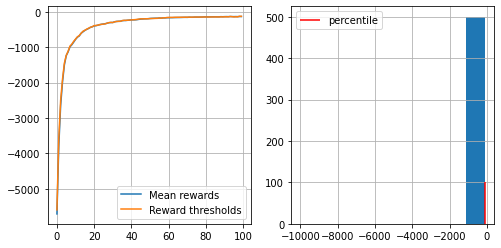

You Win! You may stop training now via KeyboardInterrupt.


In [ ]:
for i in range(50):
    # generate new sessions
    sessions = [generate_session_with_agent(env, agent_mountain_car, t_max=int(1e4)) for i in tqdm(range(n_sessions))]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent_mountain_car.partial_fit(elite_states, elite_actions)

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    show_progress(rewards_batch, log, percentile, reward_range=[-10000, np.max(rewards_batch)])

    if np.mean(rewards_batch) > min_reward:
        print("You Win! You may stop training now via KeyboardInterrupt.")

We can see that in 100 epochs mean reward gets higher than the baseline of -150.

In [ ]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session_with_agent(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

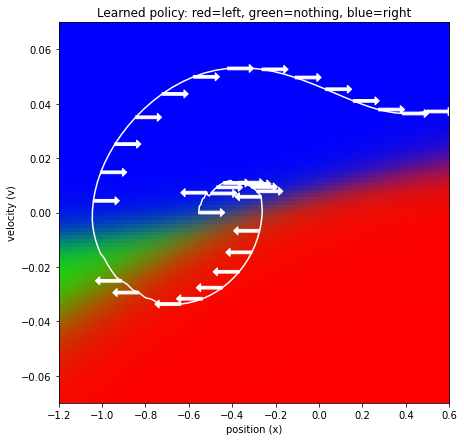

In [ ]:
with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent_mountain_car)

In [ ]:
import os
print(os.cpu_count())

2


There is only two cpus available on colab, so the speed up of parallel is not noticable, but I've added it anyway

In [ ]:
np.random.seed(1992)
env, agent_mountain_car = init(env)
%timeit sessions = [generate_session_with_agent(env, agent_mountain_car, t_max=int(1e4)) for i in range(n_sessions)]

1 loop, best of 3: 2min 22s per loop


In [ ]:
np.random.seed(1992)
agent_mountain_car = MLPClassifier(
        hidden_layer_sizes=(20, 20),
        activation='tanh',
    )
agent_mountain_car.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
%timeit sessions = Parallel(n_jobs=2)(delayed(create_env_generate_session)(agent_mountain_car, t_max=int(1e4)) for i in range(n_sessions))

1 loop, best of 3: 2min 16s per loop


mean reward = -140.712, threshold=-145.000


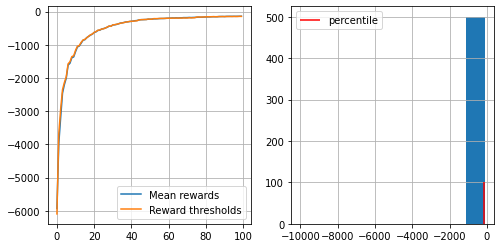




100%|██████████| 100/100 [1:56:13<00:00, 69.74s/it]

You Win! You may stop training now via KeyboardInterrupt.


In [ ]:
from collections import deque as queue
from tqdm import tqdm

np.random.seed(1992)
history_len = 3
n_sessions = 500 #// 2
percentile = 45
min_reward = -150
log = []
env, agent_mountain_car = init(env)
states_history, actions_history, rewards_history = [], [], []

for i in tqdm(range(100)):
    sessions = Parallel(n_jobs=os.cpu_count())(delayed(create_env_generate_session)(agent_mountain_car, t_max=int(1e4)) for i in range(n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    if i >= history_len:
        states_history = states_history[n_sessions:]
        actions_history = actions_history[n_sessions:]
        rewards_history = rewards_history[n_sessions:]

    states_history.extend(states_batch)
    actions_history.extend(actions_batch)
    rewards_history.extend(rewards_batch)

    elite_states, elite_actions = select_elites(states_history, actions_history, rewards_history, percentile)

    agent_mountain_car.partial_fit(elite_states, elite_actions)

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    show_progress(rewards_batch, log, percentile, reward_range=[-10000, np.max(rewards_batch)])

    if np.mean(rewards_batch) > min_reward:
        print("You Win! You may stop training now via KeyboardInterrupt.")

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.


If you're still feeling unchallenged, consider the project (see other notebook in this folder).